# A hierarchical binomial model for rat-tumor problem
author: [@karm-patel](https://karm-patel.github.io/)

We fit a hierarchical beta-binomial model to some count data derived from rat survival. We use Blackjax's HMC method for inference.  Based on https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-hierarchical-binomial-model.html

See also [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/book2/03/hierarchical_binom_rats_pymc3.ipynb) for a pymc3 version, that automagically performs change of variables.

See also [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/book2/03/change_of_variable_hmc.ipynb) for an illustration of 
 the deleterious effects of forgetting to apply the change of variable formula.



Here is the model:

![image.png](https://github.com/karm-patel/karm-patel.github.io/blob/master/images/binomial_hierarchichal.png?raw=True)



$y_{j} \sim \text{Binom}(N_{j}, \theta_{j})$

$\theta_{j} \sim \text{Beta}(a, b)$

$p(a, b) \propto (a+b)^{-5/2}$


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pandas as pd

pd.set_option("display.max_rows", 80)


try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt blackjax
    import blackjax


try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.blackjax_utils import inference_loop, inference_loop_multiple_chains, arviz_trace_from_states


tfd = tfp.distributions

In [ ]:
# to save latexified plots
# import os
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures/"

In [ ]:
# fmt: off
n_of_positives = jnp.array( [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 5, 3, 2, 7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 6, 16, 15, 15, 9, 4, ], dtype=jnp.float32)
group_size = jnp.array( [ 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19, 46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20, 48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46, 47, 24, 14, ], dtype=jnp.float32)
n_rat_tumors = len(group_size)  # number of different kind of rat tumors
# fmt: on

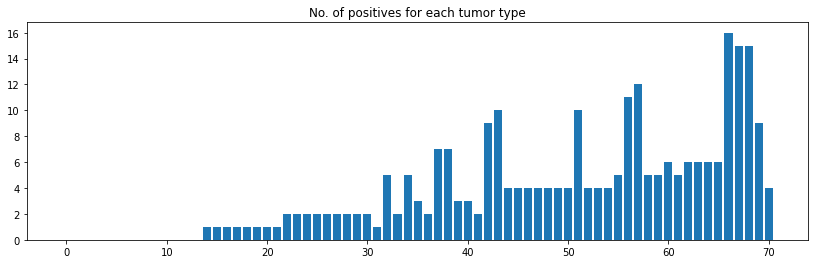

In [ ]:
plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), n_of_positives)
plt.title("No. of positives for each tumor type");

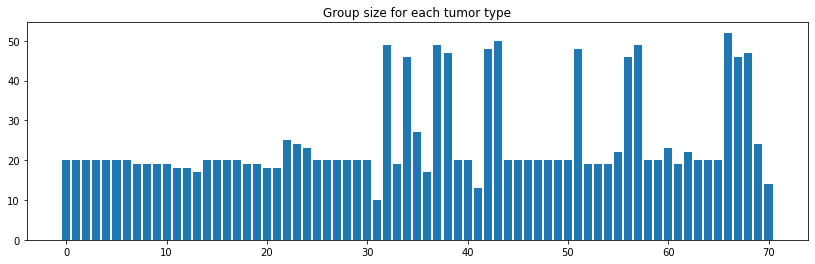

In [ ]:
plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), group_size)
plt.title("Group size for each tumor type");

In [ ]:
jacobian_fn = jax.jacfwd(jax.nn.sigmoid)


def joint_log_prob(params):
    a, b, logits = params["a"], params["b"], params["logits"]

    # HMC requires unconstrained sample space, thus it samples logits and we apply change of variable to
    # get theta from logits
    thetas = jax.nn.sigmoid(logits)
    log_det_jacob = jnp.sum(
        jax.vmap(lambda logit: jnp.log(jnp.abs(jnp.linalg.det(jacobian_fn(logit.reshape(1, 1))))))(logits)
    )

    # improper prior for a,b
    logprob_ab = jnp.log(jnp.power(a + b, -2.5))

    # logprob prior of theta
    logprob_thetas = tfd.Beta(a, b).log_prob(thetas).sum()

    # loglikelihood of y
    logprob_y = jnp.sum(
        jax.vmap(lambda y, N, theta: tfd.Binomial(N, probs=theta).log_prob(y))(n_of_positives, group_size, thetas)
    )

    return logprob_ab + logprob_thetas + logprob_y + log_det_jacob

In [ ]:
rng_key = jax.random.PRNGKey(82)
n_params = n_rat_tumors + 2


def init_param_fn(seed):
    """
    initialize a, b & logits
    """
    key1, key2 = jax.random.split(seed)
    return {
        "a": tfd.Uniform(0, 3).sample(seed=key1),
        "b": tfd.Uniform(0, 3).sample(seed=key2),
        "logits": tfd.Uniform(-2, 2).sample(n_rat_tumors, seed),
    }


initial_params = init_param_fn(rng_key)
joint_log_prob(initial_params)

DeviceArray(-1072.9049, dtype=float32)

In [ ]:
inverse_mass_matrix = jnp.array([0.5] * (n_params))
step_size = 0.05
nuts = blackjax.nuts(joint_log_prob, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix)

In [ ]:
# nuts kernel
n_chains = 4
keys = jax.random.split(rng_key, n_chains)
initial_states = jax.vmap(lambda seed: nuts.init(init_param_fn(seed)))(keys)
kernel = jax.jit(nuts.step)

In [ ]:
%%time
n_samples = 1500
states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, n_samples, n_chains)

CPU times: user 9.76 s, sys: 0 ns, total: 9.76 s
Wall time: 9.67 s


In [ ]:
# convert logits samples to theta samples
states.position["thetas"] = jax.nn.sigmoid(states.position["logits"])
del states.position["logits"]

In [ ]:
# make arviz trace from states
trace = arviz_trace_from_states(states, infos, burn_in=500)
summ_df = az.summary(trace)
summ_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.442,0.984,1.008,4.345,0.137,0.097,58.0,86.0,1.06
b,14.571,5.990,5.774,25.509,0.863,0.618,54.0,66.0,1.06
thetas[0],0.063,0.042,0.000,0.135,0.002,0.001,568.0,1125.0,1.00
thetas[1],0.063,0.041,0.001,0.137,0.002,0.001,547.0,1051.0,1.01
thetas[2],0.063,0.042,0.000,0.139,0.001,0.001,652.0,1326.0,1.01
thetas[3],0.063,0.042,0.002,0.141,0.002,0.001,506.0,1056.0,1.01
thetas[4],0.063,0.041,0.003,0.139,0.002,0.001,582.0,1368.0,1.01
thetas[5],0.064,0.042,0.002,0.139,0.001,0.001,718.0,1219.0,1.01
thetas[6],0.065,0.042,0.003,0.143,0.001,0.001,767.0,1474.0,1.00
thetas[7],0.065,0.043,0.003,0.144,0.001,0.001,670.0,1110.0,1.01


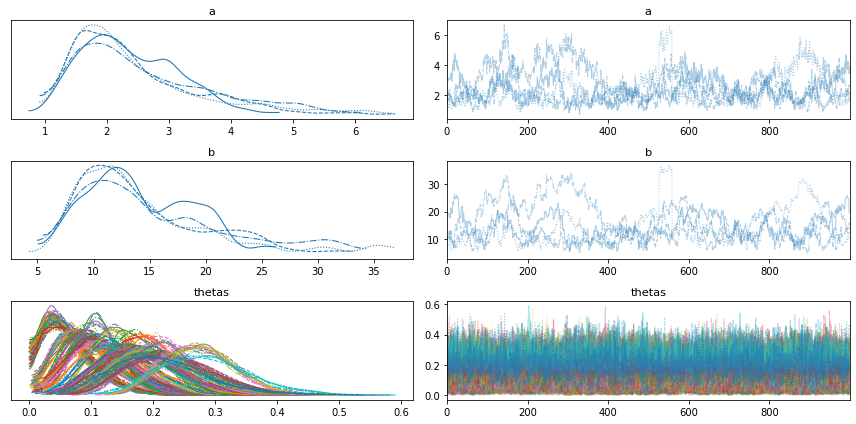

In [ ]:
az.plot_trace(trace)
plt.tight_layout()

## Theta MLE

Text(0.5, 1.0, 'Theta MLE')

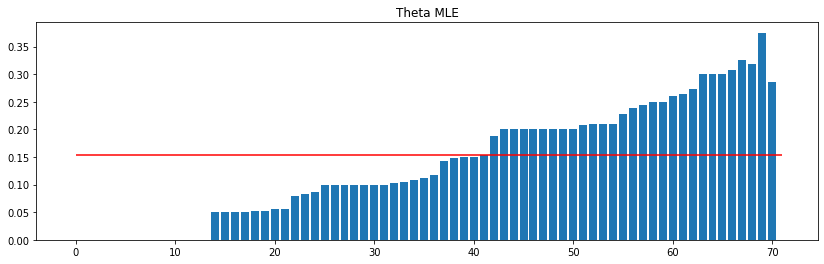

In [ ]:
theta_pooled_mle = jnp.sum(n_of_positives) / jnp.sum(group_size)
theta_mle = n_of_positives / group_size

plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), theta_mle)
plt.hlines(theta_pooled_mle, 0, n_rat_tumors, color="red")
plt.title("Theta MLE")

## Theta Posterior 

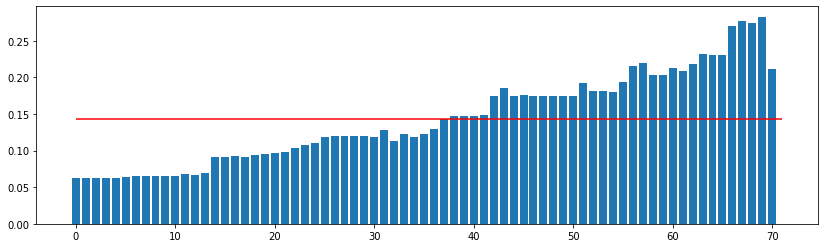

In [ ]:
theta_population_mean = summ_df["mean"][0] / (summ_df["mean"][0] + summ_df["mean"][1])  # a/(a+b)

plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), summ_df["mean"][2:])
plt.hlines(theta_population_mean, 0, n_rat_tumors, color="red")

In [ ]:
pml.latexify(fig_width=6 * 0.6, fig_height=3)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


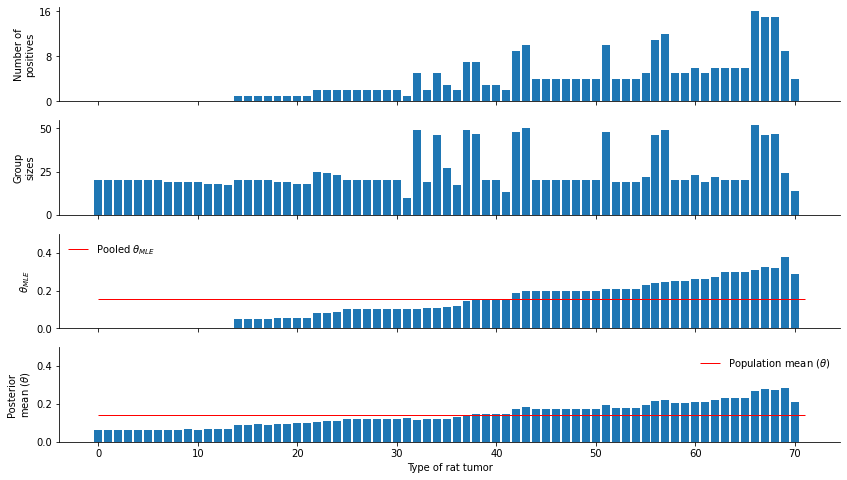

In [ ]:
FIG_SIZE = None if pml.is_latexify_enabled() else (14, 8)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=FIG_SIZE)
x = range(n_rat_tumors)

# number of positives of each tumor type
ax1.bar(x, n_of_positives)
ax1.set_ylabel("Number of\npositives")
ax1.set_yticks([0, 8, 16])

# Group size for each tumor type
ax2.bar(x, group_size)
ax2.set_ylabel("Group\nsizes")
ax2.set_yticks([0, 25, 50])

# theta MLE
theta_pooled_mle = jnp.sum(n_of_positives) / jnp.sum(group_size)
theta_mle = n_of_positives / group_size

ax3.bar(x, theta_mle)
ax3.hlines(theta_pooled_mle, 0, n_rat_tumors, color="red", label="Pooled $\\theta_{MLE}$", linewidth=1)
ax3.set_ylabel("$\\theta_{MLE}$")
ax3.set_ylim(0, 0.5)
ax3.set_yticks([0, 0.2, 0.4])
ax3.legend(frameon=False)

# Posterior mean
a_mean = summ_df["mean"][0]  # concentration1 of beta
b_mean = summ_df["mean"][1]  # concentration0 of beta

theta_population_mean = a_mean / (a_mean + b_mean)
ax4.bar(x, summ_df["mean"][2:])
ax4.hlines(theta_population_mean, 0, n_rat_tumors, color="red", label="Population mean ($\\theta$)", linewidth=1)
ax4.legend(frameon=False)
ax4.set_ylabel("Posterior\nmean ($\\theta$)")
ax4.set_xlabel("Type of rat tumor")
ax4.set_ylim(0, 0.5)
ax4.set_yticks([0, 0.2, 0.4])

sns.despine()
pml.savefig("hbayes_binom_rats_barplot", tight_bbox=True)

In [ ]:
pml.latexify(fig_width=6 * 0.3, fig_height=3, font_size=7)
FIG_SIZE = None if pml.is_latexify_enabled() else (3, 8)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


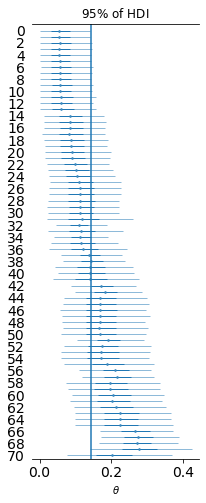

In [ ]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
az.plot_forest(trace, var_names="thetas", hdi_prob=0.95, combined=True, ax=ax, markersize=2, linewidth=0.5)
y_lims = ax.get_ylim()
ax.vlines(theta_population_mean, *y_lims)
ax.set_title("$95\%$ of HDI")
labels = []
for i in range(n_rat_tumors - 1, -1, -1):
    if i % 2 == 0:
        labels.append(str(i))
    else:
        labels.append("")

ax.set_yticklabels(labels)
ax.set_xlabel("$\\theta$")
pml.savefig("hbayes_binom_rats_forest95")